In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(13847942484)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
print(survivalstan.models.pem_survival_model_timevarying)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

functions {
  matrix spline(vector x, int N, int H, vector xi, int P) {
    matrix[N, H + P] b_x;         // expanded predictors
    for (n in 1:N) {
        for (p in 1:P) {
            b_x[n,p] <- pow(x[n],p-1);  // x[n]^(p-1)
        }
        for (h in 1:H)
          b_x[n, h + P] <- fmax(0, pow(x[n] - xi[h],P-1)); 
    }
    return b_x;
  }
}
data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
 

In [13]:
d = survivalstan.sim.sim_data_exp_correlated(N=100,
                                             censor_time=20,
                                             rate_form='1 + sex',
                                             rate_coefs=[-3, 0.5])
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,58,male,0.082085,0.535525,0.535525,True,0,4.16
1,59,male,0.082085,9.138646,9.138646,True,1,5.16
2,60,female,0.049787,5.710299,5.710299,True,2,6.16
3,53,female,0.049787,3.977168,3.977168,True,3,-0.84
4,50,female,0.049787,16.541291,16.541291,True,4,-3.84


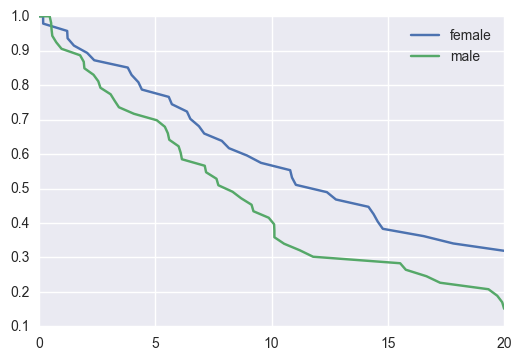

In [14]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [15]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')

In [16]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,58,male,0.082085,0.535525,0.535525,True,0,4.16,1,0.535525,True
6,58,male,0.082085,0.535525,0.535525,True,0,4.16,1,0.176064,False
24,58,male,0.082085,0.535525,0.535525,True,0,4.16,1,0.171903,False
32,58,male,0.082085,0.535525,0.535525,True,0,4.16,1,0.516488,False
67,58,male,0.082085,0.535525,0.535525,True,0,4.16,1,0.453972,False


In [17]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_timevarying,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 1000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanfit.chains_4.data_30261293600.iter_1000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:01:06.512427 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/stancache/stancache.py:198: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be

In [8]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

              mean       se_mean            sd          2.5%           50%         97.5%      Rhat
lp__ -1.126136e+21  1.360282e+21  1.373818e+22 -3.984898e+21 -1.551921e+17 -1.208859e+14  1.024024


In [20]:
survivalstan.utils.print_stan_summary(testfit['fit'], pars='beta_time')

                     mean   se_mean        sd       2.5%       50%     97.5%         Rhat
beta_time[0,0]   0.573788  0.530623  0.750414  -0.564666  0.739693  1.383371          NaN
beta_time[1,0]  -0.312773  0.600120  0.848698  -0.914583 -0.754540  1.160766   187.331142
beta_time[0,1]   0.351949  1.190151  1.683128  -1.271304 -0.241018  3.158683          NaN
beta_time[1,1]   0.036636  0.335892  0.475023  -0.450156 -0.074432  0.756190    52.424130
beta_time[0,2]   0.360930  1.146031  1.620732  -1.033983 -0.282366  3.051249          NaN
beta_time[1,2]  -0.148353  0.402041  0.568572  -1.013469 -0.035193  0.616716    41.831683
beta_time[0,3]   0.036392  0.857483  1.212664  -1.121023 -0.396070  2.070485  1084.550868
beta_time[1,3]  -0.353331  0.255207  0.360917  -0.961301 -0.280242  0.130164    19.916370
beta_time[0,4]  -0.429801  1.417600  2.004789  -2.287405 -1.186093  2.934256  1434.392901
beta_time[1,4]  -0.729950  0.568587  0.804103  -1.401952 -1.066988  0.715320    35.505497
beta_time[

In [21]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_timevarying,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanfit.chains_4.data_30261293600.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (1:38:32.746509 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/stancache/stancache.py:198: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


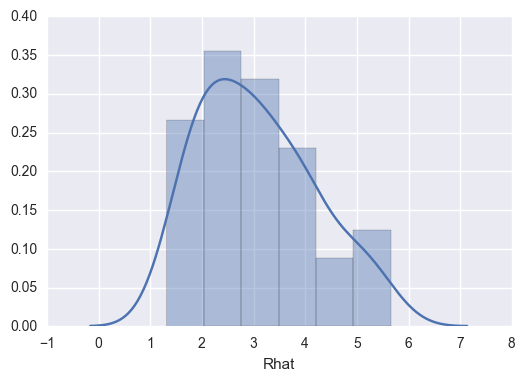

In [22]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline')

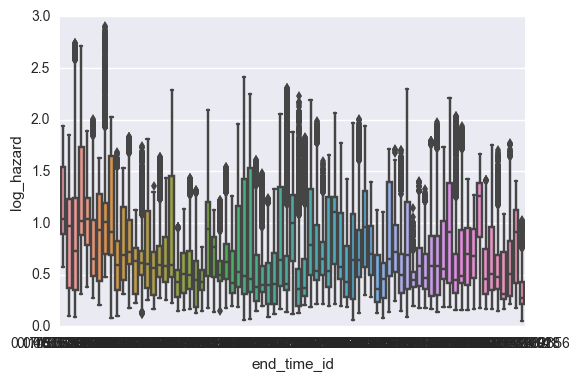

In [23]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

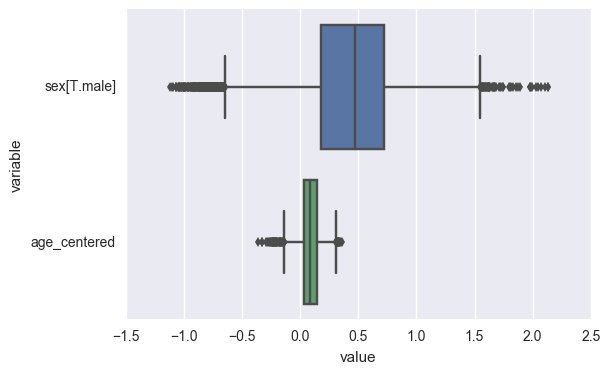

In [24]:
survivalstan.utils.plot_coefs([testfit])

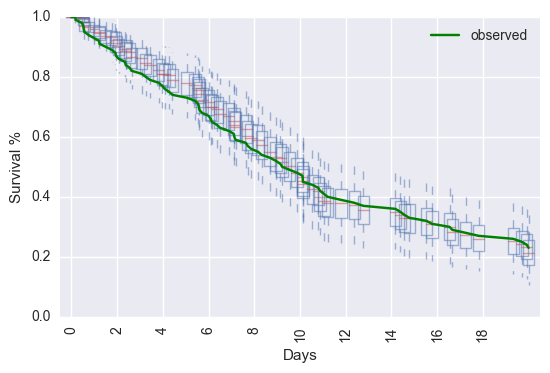

In [25]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

In [26]:
ppsurv = survivalstan.utils.prep_pp_survival_data([testfit], sample_col='index', by='sex')

In [27]:
ppsurv.head()

,iter,model_cohort,sex,level_3,event_time,survival
0,0,test model,female,0,0.000000,1.000000
1,0,test model,female,1,1.207921,1.000000
2,0,test model,female,2,1.947189,0.990650
3,0,test model,female,3,2.340973,0.984553
4,0,test model,female,4,2.370922,0.968293


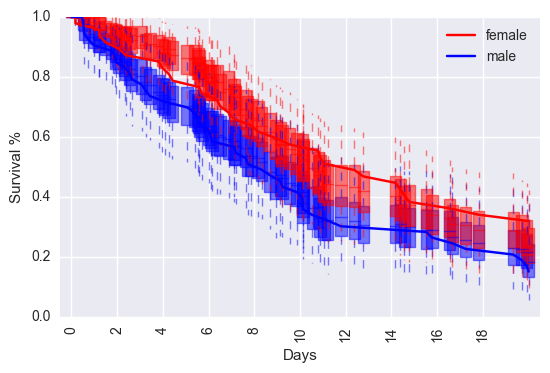

In [28]:
subplot = plt.subplots(1, 1)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "male"').copy(), subplot=subplot, color='blue', alpha=0.5)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "female"').copy(), subplot=subplot, color='red', alpha=0.5)
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()

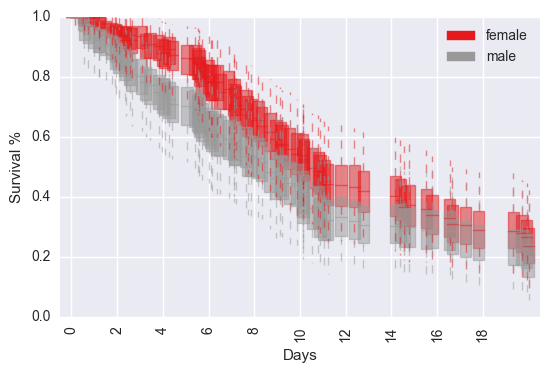

In [29]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

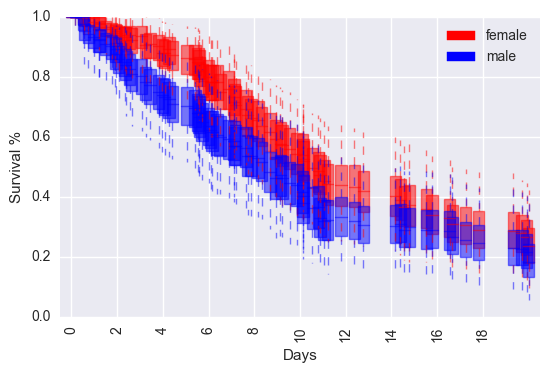

In [30]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])